# **Project 4: Image Classification**
## Because my results from this project are so poor, I am putting a summary here, with a few comments throughout the notebook and a concluding comment at the end.  Below those comments I have included some of the alternative method I was using earlier in the week, which did produce some results.
### I was not able to train a CNN that could learn.  I informed you that I was having issues that I thought stemmed from the way I was loading the data.  I thought I resolved those issues this morning (Sunday May 17), but from there it's been one step forward and two steps back.  To solve the problem of getting the data, I was not using a totally new method, just reshaping an array and encoding the target as integers.  But my loss suddenly started registering only as nan and the accuracy went to zero.  
### While I was having problems all week, I had been able to train models that reported varying accuracies from the 30s up to the low 90s and losses from a high over over 3.8 down to very small values close to zero.   I believe I did use the appropriate loss for integer-encoded labels, the sparse categorical crossentropy.  Attempting to use the plain categorical crossentropy throws a shape mismatch error.  I am not sure where I go so wrong that the loss becomes nan.  The labels are integer encoded, and I could not figure out how to one-hot encode them.  I also couldn't figure out how to make the StandardScaler work on a 4-D training set, though I tried.    
### Since the accuracy is nil there isn't much to read on the graphs, and because the network did not learn, the true and y_pred arrays are full of two different single values, which causes an error. 
### I am surprised the project ended up going this poorly.  Working with image data was surprisingly confusing, and I felt like I was attempting to catch up with the errors I was getting the whole time.

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sbn

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import SGD
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import Resizing

# Do I need this?  Maybe not?  {Probably not.}
from keras.wrappers.scikit_learn import KerasClassifier

import os
from google.colab import drive
import cv2 
from google.colab.patches import cv2_imshow

import PIL

# **Mount drive**

In [2]:

drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
directory = 'drive/My Drive/facesDB'

# **Show an image**

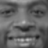

In [9]:
img_path = directory + '/S22/7.BMP'
img = cv2.imread(img_path)
cv2_imshow(img)

# **Get data**
## I am reading the files into an initialized numpy array and also collecting their labels in another array, as strings but they will be cast to ints.

In [10]:
loc = os.listdir(directory)

In [11]:
data = np.ones((400, (48*48)))
labels = []
for i, l in enumerate(loc):
 # print(i)
  if i != 0:
    # I also need to get the folder name for each image and append it as the target. Will be cast to int below.
    labels.append((l.replace('S', ' ')*10).split())  
    
    # Full image path
    path = img_path

    img = np.asarray(PIL.Image.open(path))

    # Make a vector from an image
    img = img.reshape(-1, img.size)
    img.shape

    # store this vector
    data[i,:]  = img

# **Creating a DataFrame from the pixel data**
## Then casting the labels to ints and appending them to the dataframe as a column 'target'

In [12]:
df = pd.DataFrame(data)

In [13]:
print(labels)

[['4', '4', '4', '4', '4', '4', '4', '4', '4', '4'], ['33', '33', '33', '33', '33', '33', '33', '33', '33', '33'], ['2', '2', '2', '2', '2', '2', '2', '2', '2', '2'], ['32', '32', '32', '32', '32', '32', '32', '32', '32', '32'], ['35', '35', '35', '35', '35', '35', '35', '35', '35', '35'], ['26', '26', '26', '26', '26', '26', '26', '26', '26', '26'], ['19', '19', '19', '19', '19', '19', '19', '19', '19', '19'], ['5', '5', '5', '5', '5', '5', '5', '5', '5', '5'], ['3', '3', '3', '3', '3', '3', '3', '3', '3', '3'], ['34', '34', '34', '34', '34', '34', '34', '34', '34', '34'], ['17', '17', '17', '17', '17', '17', '17', '17', '17', '17'], ['10', '10', '10', '10', '10', '10', '10', '10', '10', '10'], ['20', '20', '20', '20', '20', '20', '20', '20', '20', '20'], ['29', '29', '29', '29', '29', '29', '29', '29', '29', '29'], ['18', '18', '18', '18', '18', '18', '18', '18', '18', '18'], ['11', '11', '11', '11', '11', '11', '11', '11', '11', '11'], ['21', '21', '21', '21', '21', '21', '21', '21'

In [14]:
tar = [] 
for each in labels:
  for all in each:
    tar.append(int(all))

In [15]:
df['target'] = tar

In [16]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2265,2266,2267,2268,2269,2270,2271,2272,2273,2274,2275,2276,2277,2278,2279,2280,2281,2282,2283,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303,target
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4
1,117.0,117.0,119.0,120.0,121.0,123.0,128.0,133.0,136.0,140.0,146.0,155.0,162.0,167.0,167.0,166.0,163.0,156.0,154.0,157.0,162.0,162.0,161.0,160.0,161.0,160.0,157.0,154.0,151.0,149.0,144.0,137.0,128.0,123.0,118.0,112.0,107.0,102.0,96.0,90.0,...,104.0,108.0,108.0,106.0,103.0,101.0,98.0,95.0,90.0,85.0,81.0,79.0,79.0,79.0,79.0,78.0,78.0,75.0,70.0,63.0,58.0,57.0,59.0,62.0,67.0,74.0,81.0,85.0,85.0,83.0,85.0,89.0,89.0,78.0,60.0,51.0,49.0,49.0,44.0,4
2,117.0,117.0,119.0,120.0,121.0,123.0,128.0,133.0,136.0,140.0,146.0,155.0,162.0,167.0,167.0,166.0,163.0,156.0,154.0,157.0,162.0,162.0,161.0,160.0,161.0,160.0,157.0,154.0,151.0,149.0,144.0,137.0,128.0,123.0,118.0,112.0,107.0,102.0,96.0,90.0,...,104.0,108.0,108.0,106.0,103.0,101.0,98.0,95.0,90.0,85.0,81.0,79.0,79.0,79.0,79.0,78.0,78.0,75.0,70.0,63.0,58.0,57.0,59.0,62.0,67.0,74.0,81.0,85.0,85.0,83.0,85.0,89.0,89.0,78.0,60.0,51.0,49.0,49.0,44.0,4
3,117.0,117.0,119.0,120.0,121.0,123.0,128.0,133.0,136.0,140.0,146.0,155.0,162.0,167.0,167.0,166.0,163.0,156.0,154.0,157.0,162.0,162.0,161.0,160.0,161.0,160.0,157.0,154.0,151.0,149.0,144.0,137.0,128.0,123.0,118.0,112.0,107.0,102.0,96.0,90.0,...,104.0,108.0,108.0,106.0,103.0,101.0,98.0,95.0,90.0,85.0,81.0,79.0,79.0,79.0,79.0,78.0,78.0,75.0,70.0,63.0,58.0,57.0,59.0,62.0,67.0,74.0,81.0,85.0,85.0,83.0,85.0,89.0,89.0,78.0,60.0,51.0,49.0,49.0,44.0,4
4,117.0,117.0,119.0,120.0,121.0,123.0,128.0,133.0,136.0,140.0,146.0,155.0,162.0,167.0,167.0,166.0,163.0,156.0,154.0,157.0,162.0,162.0,161.0,160.0,161.0,160.0,157.0,154.0,151.0,149.0,144.0,137.0,128.0,123.0,118.0,112.0,107.0,102.0,96.0,90.0,...,104.0,108.0,108.0,106.0,103.0,101.0,98.0,95.0,90.0,85.0,81.0,79.0,79.0,79.0,79.0,78.0,78.0,75.0,70.0,63.0,58.0,57.0,59.0,62.0,67.0,74.0,81.0,85.0,85.0,83.0,85.0,89.0,89.0,78.0,60.0,51.0,49.0,49.0,44.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,24
396,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,24
397,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,24
398,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.

# **Creating train and test sets with an 80/20 split**
## The reshaping got around initial errors I was running into. 

In [17]:
X = df.drop(columns=['target'])
Y = df['target']

In [18]:
X = X.values.reshape(-1,48,48,1)

In [19]:
X.shape

(400, 48, 48, 1)

In [20]:
Y = Y.values.reshape(-1,1)

In [21]:
Y.shape

(400, 1)

In [22]:
trainX, testX, trainY, testY = train_test_split(X, Y, train_size = 0.80, 
                                                      test_size = 0.20,
                                                      random_state = 215)

# **Model training**

In [23]:
def create_compile_model_1():
  model = Sequential([
  Conv2D(256, 7, activation="relu", kernel_initializer='he_uniform',  input_shape=[48, 48, 1]),
  MaxPooling2D(2),
  Flatten(),
  Dense(256, activation="relu", kernel_initializer='he_uniform', ),
  Dense(80, activation="relu", kernel_initializer='he_uniform', ),
  layers.Dense(40, activation='softmax')
  ])
  opt = SGD(lr=0.05, momentum=0.25)
  model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
 
  return model


## Data augmentation was something I hoped to use to get better results but never really got to experiment with.  This example is from the tutorial below.
---
#### https://www.tensorflow.org/tutorials/images/classification

In [24]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(48, 48,1)), 
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


In [25]:
batch_size = 32
img_height = 48
img_width = 48

In [26]:
model = create_compile_model_1()

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 42, 42, 256)       12800     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 256)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 112896)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               28901632  
_________________________________________________________________
dense_4 (Dense)              (None, 80)                20560     
_________________________________________________________________
dense_5 (Dense)              (None, 40)                3240      
Total params: 28,938,232
Trainable params: 28,938,232
Non-trainable params: 0
__________________________________________

# **I'm only creating this one model since none are learning at all right now.**

In [28]:
history1 = model.fit(trainX, trainY,
                     epochs=100, 
                     batch_size=128, 
                     validation_data=(testX, testY), 
                     )

Epoch 1/100
3/3 [==============================] - 33s 391ms/step - loss: nan - accuracy: 0.0180 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 0s 50ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 0s 46ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/100
3/3 [==============================] - 0s 46ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/100
3/3 [==============================] - 0s 47ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/100
3/3 [==============================] - 0s 53ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/100
3/3 [==============================] - 0s 51ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 8/

# **Graph Section**

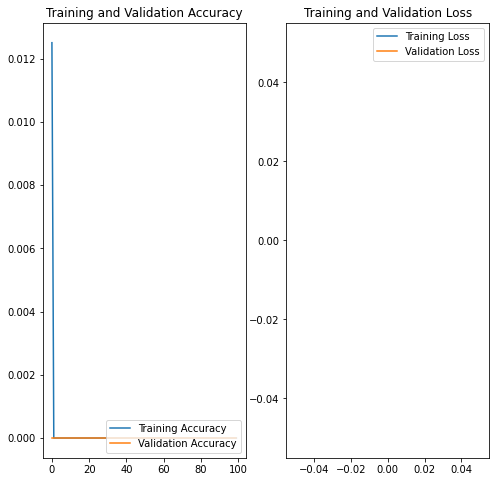

In [29]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
labels = list(range(1,41))

In [26]:
y_pred = model.predict_classes(testX)
y_pred

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
y_true = np.argmax(testY, axis=-1)

In [28]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels)

ValueError: ignored

# **Final note**  
## After writing this up and annotating the notebook I think that the problem came down to how well I understood how to use the code tools we have to prepare the data and feed it to the model.  There were times when I was not able to grasp what a given function required and why, and therefore couldn't understand the error.   I keep asking myself what I would do if this were a personal project and not an assignment and I think I would just continue working on it, searching, thinking, taking a break and coming back after a day, and likely find the answer.  Unfortunately there are deadlines sometimes.  

# **This is an example of the workflow I was in for most of the week until deciding that this method of getting the data was too problematic.  (One problem seemed to be TF's spotty support for grayscale BMP images.  A fix was claimed in 2017 but the error I got repeatedly suggested otherwise. I considered converting the images to png to try and help but that seemed like the wrong direction.)**

In [ ]:
train = image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",    # When grayscale didn't work I used rgb and then reshaped the data later, the main reason I abandoned this method.
    batch_size=32,
    image_size=(48, 48),
    shuffle=True,
    seed=11,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
)
val = image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(48, 48),
    shuffle=True,
    seed=11,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
)

Found 400 files belonging to 40 classes.
Using 320 files for training.
Found 400 files belonging to 40 classes.
Using 80 files for validation.


In [ ]:
batch_size = 32
img_height = 48
img_width = 48

In [ ]:
num_classes = 40  

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  Conv2D(128, 7, activation="relu", kernel_initializer='he_uniform',  input_shape=[48, 48, 1]),
  MaxPooling2D(2),
  Flatten(),
  Dense(128, activation="relu", kernel_initializer='he_uniform', ),
  Dropout(0.5),
  Dense(64, activation="relu", kernel_initializer='he_uniform', ),
  Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])


In [ ]:
opt = SGD(lr=0.05, momentum=0.25)  
model.compile(optimizer=opt,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])


In [ ]:
 model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 48, 48, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 128)       18944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 56448)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               7225472   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [ ]:
epochs=300
history = model.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/300
10/10 [==============================] - 1s 39ms/step - loss: 14.7030 - accuracy: 0.0167 - val_loss: 3.6893 - val_accuracy: 0.0125
Epoch 2/300
10/10 [==============================] - 0s 27ms/step - loss: 3.6841 - accuracy: 0.0073 - val_loss: 3.6845 - val_accuracy: 0.0625
Epoch 3/300
10/10 [==============================] - 1s 27ms/step - loss: 3.6667 - accuracy: 0.0523 - val_loss: 3.6774 - val_accuracy: 0.0125
Epoch 4/300
10/10 [==============================] - 1s 26ms/step - loss: 3.6546 - accuracy: 0.0293 - val_loss: 3.6602 - val_accuracy: 0.1000
Epoch 5/300
10/10 [==============================] - 0s 26ms/step - loss: 3.6405 - accuracy: 0.0224 - val_loss: 3.6644 - val_accuracy: 0.0625
Epoch 6/300
10/10 [==============================] - 1s 28ms/step - loss: 3.6293 - accuracy: 0.0555 - val_loss: 3.6386 - val_accuracy: 0.1125
Epoch 7/300
10/10 [==============================] - 1s 28ms/step - loss: 3.5598 - accuracy: 0.0956 - val_loss: 3.6098 - val_accuracy: 0.0500
Epoch

In [ ]:
val


<BatchDataset shapes: ((None, 48, 48, 3), (None,)), types: (tf.float32, tf.int32)>

# Plot Results

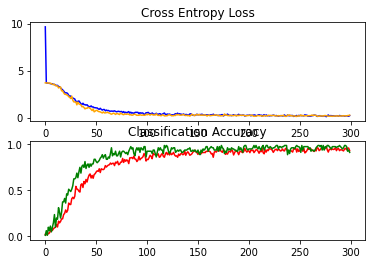

In [ ]:
# plot loss
plt.subplot(2, 1, 1)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')

# plot accuracy
plt.subplot(2, 1, 2)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='green', label='test')

plt.show()

## The error when I try to plot the training vs validation accuracy/loss values is: ValueError: x and y must have same first dimension, but have shapes (100,) and (300,)

### I saw this error in the context of using both input methods but it seemed to come and go unexpectedly.  I did not pin down a concrete cause.

ValueError: ignored

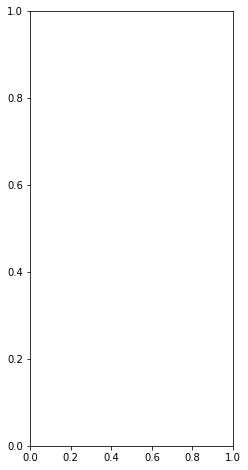

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()